In [371]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [372]:
df = pd.read_csv("D:\\FON Cetvrta godina\\Neuronske mreže\\Projekat\\Austria.csv")

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201604 entries, 0 to 201603
Data columns (total 8 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            201604 non-null  int64  
 1   utc_timestamp                         201604 non-null  object 
 2   cet_cest_timestamp                    201604 non-null  object 
 3   AT_price_day_ahead                    131378 non-null  float64
 4   AT_solar_generation_actual            201352 non-null  float64
 5   AT_wind_onshore_generation_actual     201406 non-null  float64
 6   AT_load_forecast_entsoe_transparency  201598 non-null  float64
 7   AT_load_actual_entsoe_transparency    201598 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 12.3+ MB


In [374]:
df["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"])

In [375]:
df = df.set_index("utc_timestamp").sort_index()

In [376]:
target = "AT_price_day_ahead"
df = df[~df[target].isna()] 

In [377]:
df["cet_cest_timestamp"] = pd.to_datetime(df["cet_cest_timestamp"], utc=True)
df["cet_cest_timestamp"] = df["cet_cest_timestamp"].dt.tz_convert("CET")  # CET/CEST
df["hour"] = df["cet_cest_timestamp"].dt.hour
df["dayofweek"] = df["cet_cest_timestamp"].dt.dayofweek  # 0=Monday
df["month"] = df["cet_cest_timestamp"].dt.month

df.drop(columns=["cet_cest_timestamp"], inplace=True)

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131378 entries, 2015-01-01 00:15:00+00:00 to 2018-10-02 21:30:00+00:00
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            131378 non-null  int64  
 1   AT_price_day_ahead                    131378 non-null  float64
 2   AT_solar_generation_actual            131158 non-null  float64
 3   AT_wind_onshore_generation_actual     131186 non-null  float64
 4   AT_load_forecast_entsoe_transparency  131378 non-null  float64
 5   AT_load_actual_entsoe_transparency    131378 non-null  float64
 6   hour                                  131378 non-null  int32  
 7   dayofweek                             131378 non-null  int32  
 8   month                                 131378 non-null  int32  
dtypes: float64(5), int32(3), int64(1)
memory usage: 8.5 MB


In [379]:
df = df.drop('Unnamed: 0', axis=1)

df_copy = df.copy()
df_copy[target] = df_copy[target].interpolate(method="time").ffill().bfill()

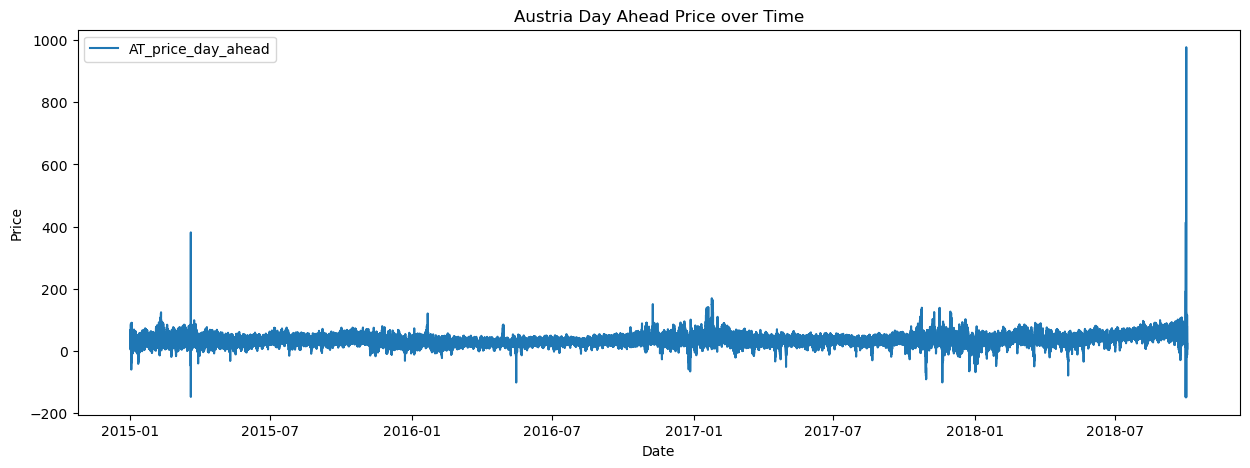

In [380]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df.index, df[target], label="AT_price_day_ahead")
plt.title("Austria Day Ahead Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [381]:
split_index = int(0.7 * len(df))
split_date = df.index[split_index]

train = df.loc[:split_date].copy()
test = df.loc[split_date:].copy()

In [382]:
features = ["hour", "dayofweek", "month",
            "AT_solar_generation_actual", 
            "AT_wind_onshore_generation_actual",
            "AT_load_forecast_entsoe_transparency",
            "AT_load_actual_entsoe_transparency"]

In [383]:
train[target] = train[target].interpolate(method="time").ffill().bfill()

In [384]:
train.head()

,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,AT_load_forecast_entsoe_transparency,AT_load_actual_entsoe_transparency,hour,dayofweek,month
utc_timestamp,,,,,,,,
2015-01-01 00:15:00+00:00,61.72,NaN,69.96,6692.23,5966.8,1,3,1
2015-01-01 00:30:00+00:00,28.00,NaN,69.80,6722.06,5935.6,1,3,1
2015-01-01 00:45:00+00:00,15.68,NaN,65.85,6689.71,5934.4,1,3,1
2015-01-01 01:00:00+00:00,65.08,NaN,62.23,6632.80,5750.8,2,3,1
2015-01-01 01:15:00+00:00,54.18,NaN,62.87,6572.90,5777.6,2,3,1


<Figure size 2000x600 with 0 Axes>

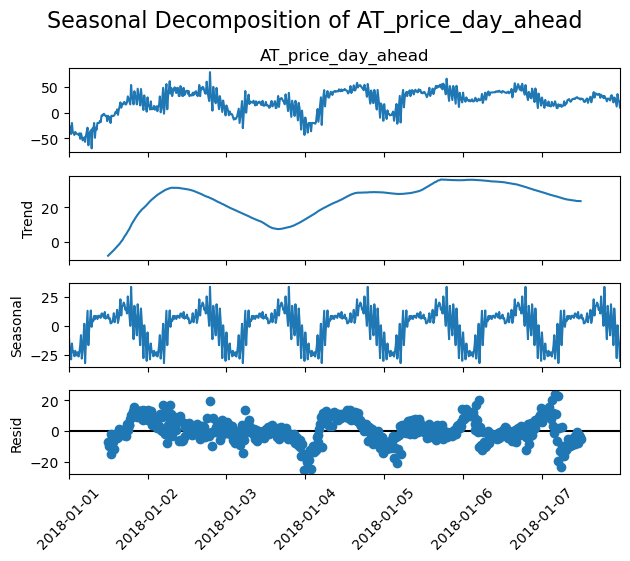

In [385]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Pretpostavljamo da je frekvencija satna; za 15-min interval koristimo period=96 (24h * 4)
decompose_period = 96  # ako je 15-min interval i želimo dnevnu sezonalnost
short_period = df_copy['2018-01-01':'2018-01-07'][target]
result = seasonal_decompose(short_period, model='additive', period=decompose_period)

# Plot komponenti
plt.figure(figsize=(20,6))
result.plot()
plt.xticks(rotation=45)
plt.suptitle("Seasonal Decomposition of AT_price_day_ahead", fontsize=16, y=1.05)
plt.show()

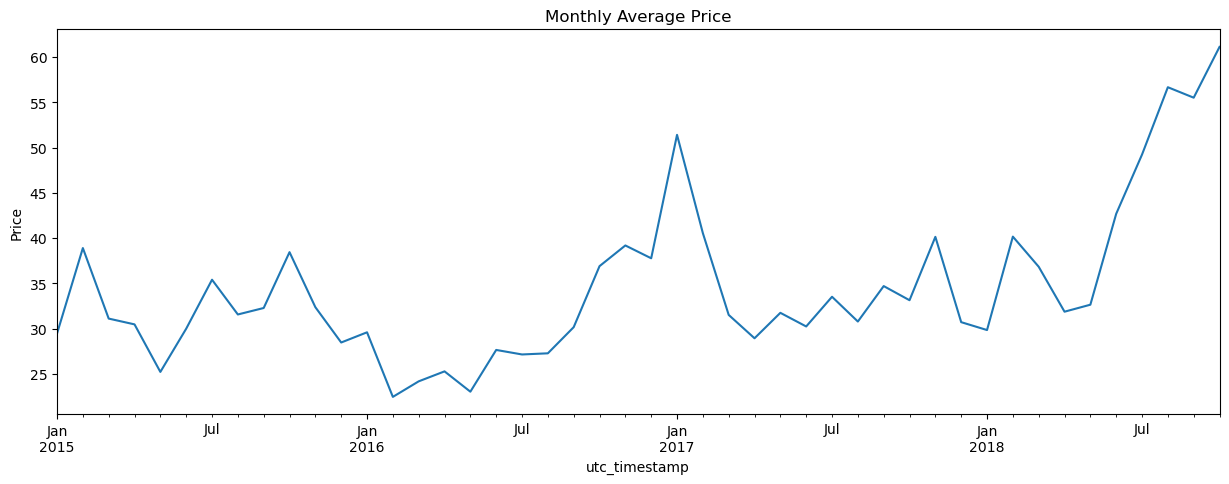

<Figure size 1000x500 with 0 Axes>

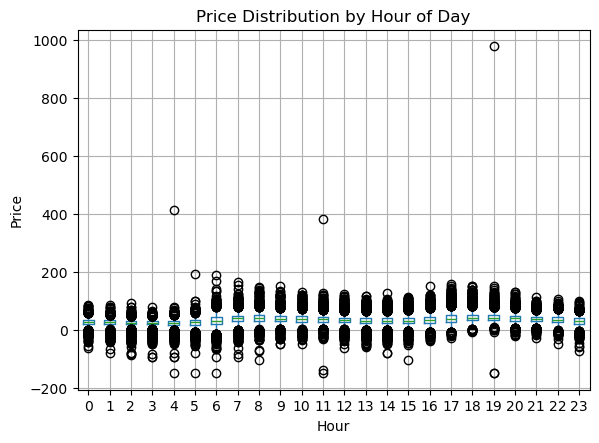

In [386]:
monthly_avg = df[target].resample('ME').mean()
plt.figure(figsize=(15,5))
monthly_avg.plot()
plt.title("Monthly Average Price")
plt.ylabel("Price")
plt.show()

plt.figure(figsize=(10,5))
df.boxplot(column=target, by="hour")
plt.title("Price Distribution by Hour of Day")
plt.suptitle("")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.show()

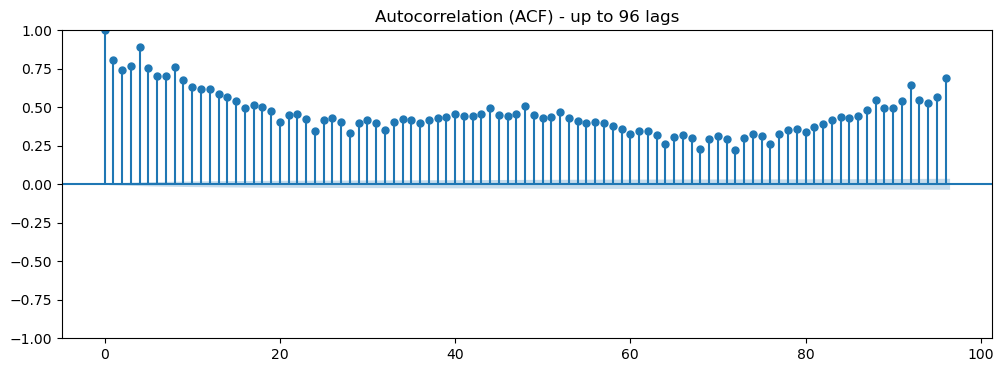

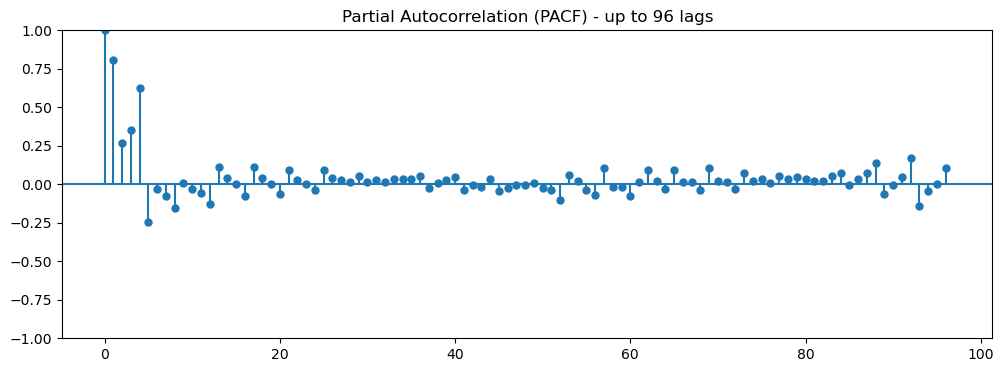

In [387]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(df[target].dropna(), lags=96, ax=plt.gca())
plt.title("Autocorrelation (ACF) - up to 96 lags")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df[target].dropna(), lags=96, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF) - up to 96 lags")
plt.show()

In [388]:

test[target] = test[target].interpolate(method="time").ffill().bfill()

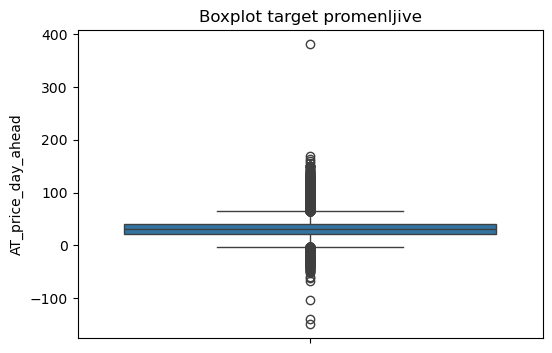

Outlier granice: -3.16, 65.53
Broj outlayera u targetu: 2523


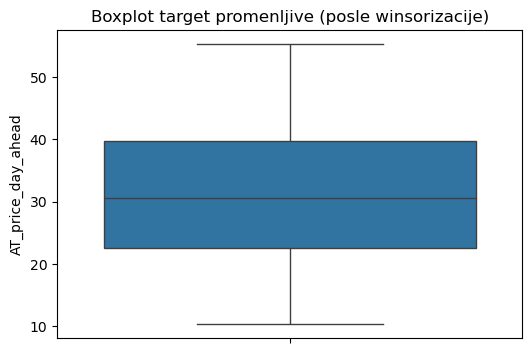

In [389]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(y=train[target])
plt.title("Boxplot target promenljive")
plt.show()

# --- 5.1. Outlier detekcija i winsorizacija targeta ---
Q1 = train[target].quantile(0.25)
Q3 = train[target].quantile(0.75)
IQR = Q3 - Q1

# Granice za outliere
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outlier granice: {lower_bound:.2f}, {upper_bound:.2f}")

outliers = train[target][(train[target] < lower_bound) | (train[target] > upper_bound)]
print(f"Broj outlayera u targetu: {len(outliers)}")

# Winsorizacija (odsecanje na 1% i 99% percentil)
low_clip = train[target].quantile(0.05)
high_clip = train[target].quantile(0.95)

train[target] = train[target].clip(lower=low_clip, upper=high_clip)

plt.figure(figsize=(6,4))
sns.boxplot(y=train[target])
plt.title("Boxplot target promenljive (posle winsorizacije)")
plt.show()

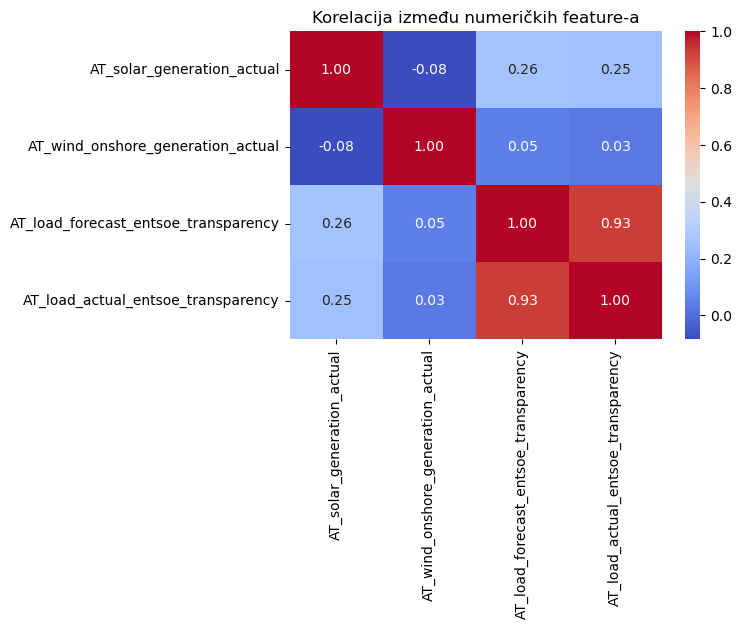

In [390]:
num_features = [
    "AT_solar_generation_actual",
    "AT_wind_onshore_generation_actual",
    "AT_load_forecast_entsoe_transparency",
    "AT_load_actual_entsoe_transparency"
]

corr_matrix = train[num_features].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelacija između numeričkih feature-a")
plt.show()

def drop_highly_correlated(train, test, target, features, 
                           high_corr_threshold=0.9, min_target_corr=0.3,
                           keep_features=["hour","dayofweek","month"]):
    corr_matrix = train[features].corr()
    to_drop = set()

    # --- 1. Visoko korelisani parovi ---
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            f1, f2 = features[i], features[j]
            corr = corr_matrix.loc[f1, f2]
            if abs(corr) > high_corr_threshold:
                # Koja je veća korelacija sa targetom?
                corr_f1 = abs(train[[f1, target]].corr().iloc[0,1])
                corr_f2 = abs(train[[f2, target]].corr().iloc[0,1])
                if corr_f1 < corr_f2:
                    to_drop.add(f1)
                else:
                    to_drop.add(f2)
                print(f"Visoko korelisani: {f1}-{f2} ({corr:.3f}) - {'f1' if corr_f1 < corr_f2 else 'f2'}")

    # --- 2. Feature-i sa malom korelacijom sa targetom ---
    for f in features:
        if f in keep_features:
            continue
        corr_with_target = abs(train[[f, target]].corr().iloc[0,1])
        if corr_with_target < min_target_corr:
            to_drop.add(f)
            print(f"Niska korelacija sa targetom: {f} ({corr_with_target:.3f}) ")

    # Drop iz train i test
    train = train.drop(columns=list(to_drop), errors="ignore")
    test  = test.drop(columns=list(to_drop), errors="ignore")

    # Ažuriramo listu feature-a
    features = [f for f in features if f not in to_drop]

    return train, test, features

Visoko korelisani: AT_load_forecast_entsoe_transparency-AT_load_actual_entsoe_transparency (0.930) - f2
Niska korelacija sa targetom: AT_solar_generation_actual (0.052) 
Niska korelacija sa targetom: AT_wind_onshore_generation_actual (0.071) 


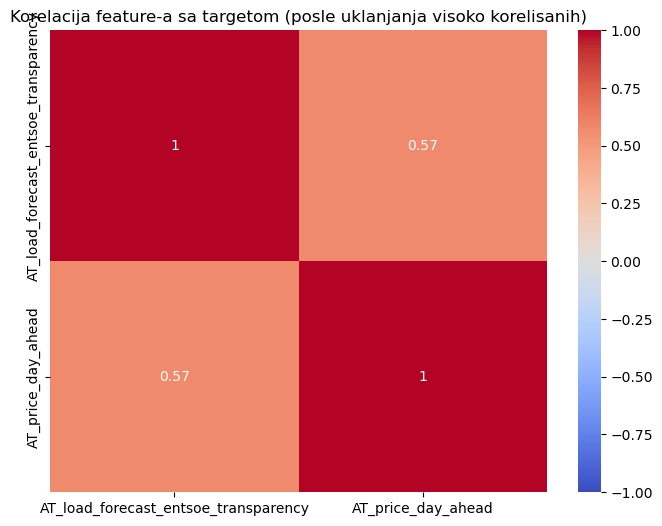

In [391]:
train, test, features = drop_highly_correlated(train, test, target, features, high_corr_threshold=0.8, min_target_corr=0.3, keep_features=["hour","dayofweek","month"])

plot_features = [f for f in features if f not in ["hour","dayofweek","month"]]
# Heatmap korelacija nakon uklanjanja visoko korelisanih
plt.figure(figsize=(8,6))
sns.heatmap(train[plot_features + [target]].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Korelacija feature-a sa targetom (posle uklanjanja visoko korelisanih)")
plt.show()

In [392]:
scaler_y = MinMaxScaler()
scaler_X = MinMaxScaler()

In [393]:
y_train_scaled = scaler_y.fit_transform(train[[target]])
y_test_scaled = scaler_y.transform(test[[target]])

In [394]:
for col in features:
    train[col] = train[col].ffill().bfill()
    test[col] = test[col].ffill().bfill()

In [395]:
X_train_scaled = scaler_X.fit_transform(train[features])
X_test_scaled = scaler_X.transform(test[features])

In [396]:
train.isna().sum()

AT_price_day_ahead                      0
AT_load_forecast_entsoe_transparency    0
hour                                    0
dayofweek                               0
month                                   0
dtype: int64

In [397]:
test.isna().sum()

AT_price_day_ahead                      0
AT_load_forecast_entsoe_transparency    0
hour                                    0
dayofweek                               0
month                                   0
dtype: int64

In [398]:
def create_sequences(y, X, look_back=24):
    X_seq, y_seq = [], []
    for i in range(len(y) - look_back):
        seq_y = y[i:i+look_back]
        feat = X[i+look_back]
        X_seq.append(np.hstack([seq_y.flatten(), feat]))
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

In [399]:
look_back = 24
X_train_seq, y_train_seq = create_sequences(y_train_scaled, X_train_scaled, look_back)
X_test_seq, y_test_seq = create_sequences(y_test_scaled, X_test_scaled, look_back)

# Preoblikovanje u 3D za RNN
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], look_back + X_train_scaled.shape[1], 1)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], look_back + X_test_scaled.shape[1], 1)

print("Train shape:", X_train_seq.shape, y_train_seq.shape)
print("Test shape:", X_test_seq.shape, y_test_seq.shape)

Train shape: (91941, 28, 1) (91941, 1)
Test shape: (39390, 28, 1) (39390, 1)


In [400]:
def build_lstm(input_shape, units=64):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

In [401]:
lstm = build_lstm((X_train_seq.shape[1], X_train_seq.shape[2]))

# Early stopping callback
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

Epoch 1/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 0.0233 - mae: 0.1139 - val_loss: 0.0534 - val_mae: 0.1410
Epoch 2/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0186 - mae: 0.1021 - val_loss: 0.0440 - val_mae: 0.1166
Epoch 3/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - loss: 0.0136 - mae: 0.0870 - val_loss: 0.0424 - val_mae: 0.1117
Epoch 4/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0119 - mae: 0.0812 - val_loss: 0.0415 - val_mae: 0.1074
Epoch 5/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - loss: 0.0108 - mae: 0.0773 - val_loss: 0.0434 - val_mae: 0.1107
Epoch 6/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0097 - mae: 0.0734 - val_loss: 0.0441 - val_mae: 0.1101
Epoch 7/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0089 - mae: 0.0706 - val_loss: 0.0388 - val_mae: 0.0989
Epoch 8/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - loss: 0.0086 - mae: 0.0694 - val_loss: 0.0366 - val_mae: 0.0969
Epoch 9/30
1437/1437 ━━━

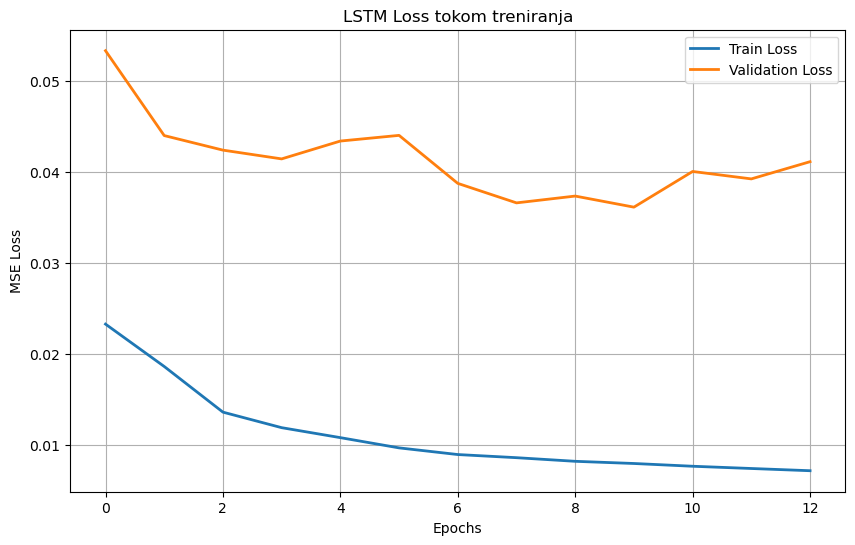

In [402]:
history = lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=30,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# Plot train vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("LSTM Loss tokom treniranja")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [403]:
loss, mae = lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Test Loss: 0.0362, Test MAE: 0.0935


1231/1231 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
y_test_seq shape: (39390, 1)
y_test_seq first 10 values: [[0.48645047]
 [0.48622834]
 [0.49355842]
 [0.43802754]
 [0.46868059]
 [0.46423812]
 [0.50555309]
 [0.34540204]
 [0.44868947]
 [0.51221679]]
y_pred_scaled shape: (39390, 1)
y_pred_scaled first 10 values: [[0.4753411 ]
 [0.4604084 ]
 [0.41699874]
 [0.431746  ]
 [0.48886353]
 [0.48402447]
 [0.53253496]
 [0.40303993]
 [0.4652189 ]
 [0.48558885]]


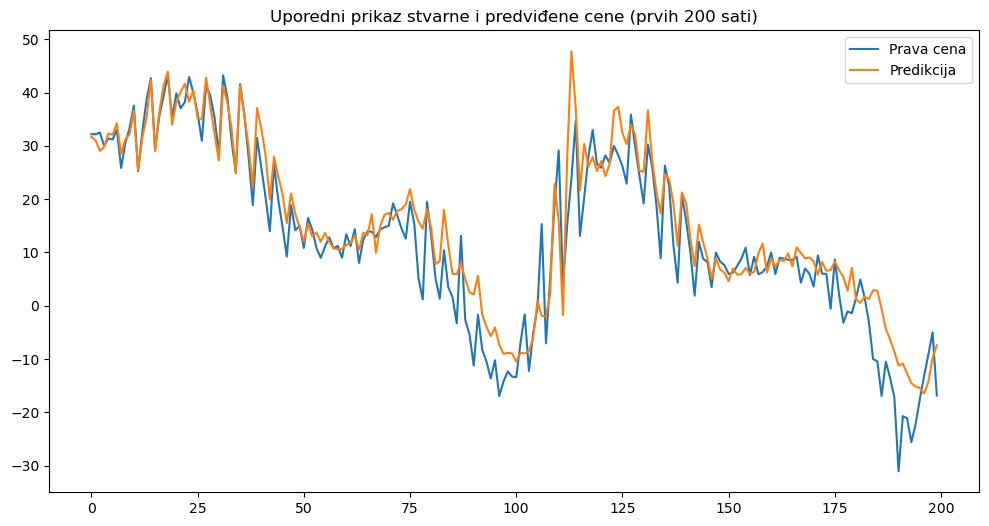

In [404]:
y_pred_scaled = lstm.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(y_true[:200], label="Prava cena")
plt.plot(y_pred[:200], label="Predikcija")
plt.legend()
plt.title("Uporedni prikaz stvarne i predviđene cene (prvih 200 sati)")
plt.show()

In [440]:
def build_gru(input_shape, units=64):
    model = Sequential([
        Input(shape=input_shape),
        GRU(units, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


In [444]:
gru = build_gru((X_train_seq.shape[1], X_train_seq.shape[2]))

Epoch 1/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0235 - mae: 0.1144 - val_loss: 0.0479 - val_mae: 0.1280
Epoch 2/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - loss: 0.0170 - mae: 0.0969 - val_loss: 0.0440 - val_mae: 0.1189
Epoch 3/30
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - loss: 0.0120 - mae: 0.0823 - val_loss: 0.0427 - val_mae: 0.1106


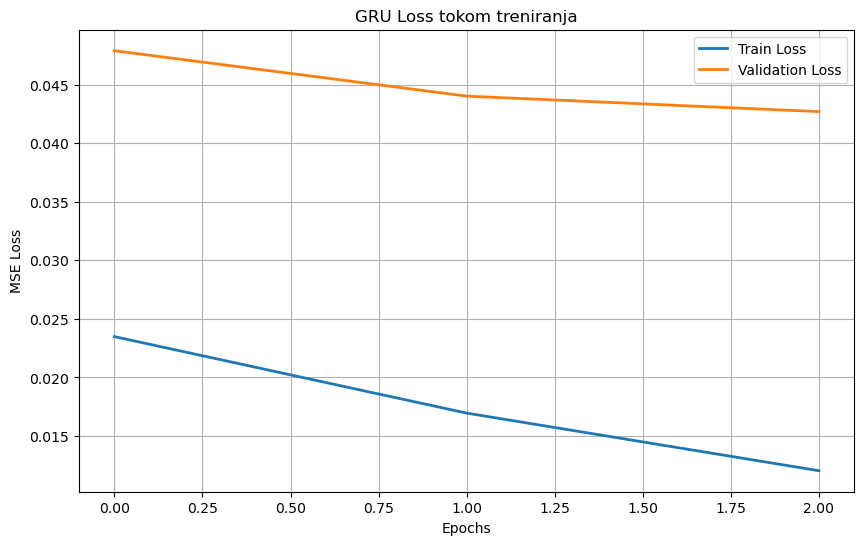

In [446]:
history_gru = gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=30,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

plt.figure(figsize=(10, 6))
plt.plot(history_gru.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history_gru.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("GRU Loss tokom treniranja")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

1231/1231 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


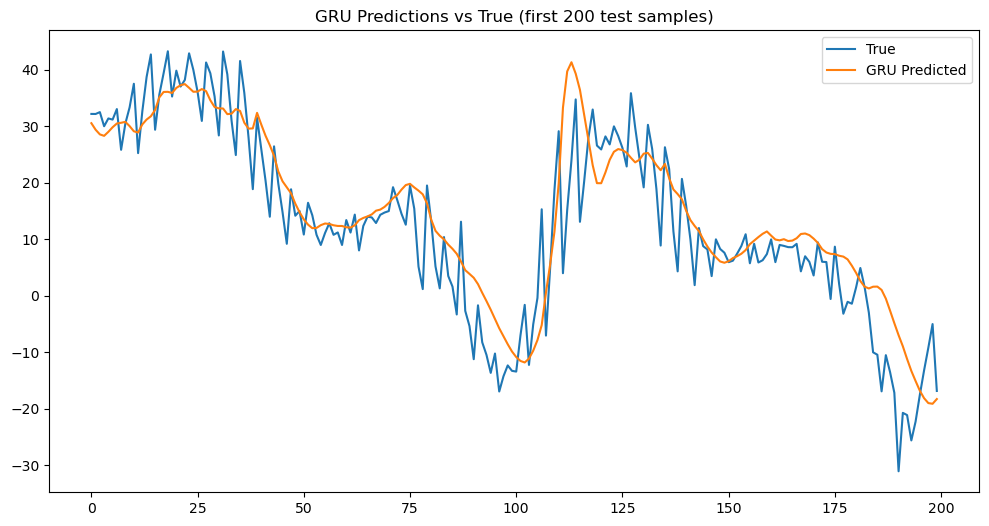

In [458]:
pred_gru_scaled = gru.predict(X_test_seq)
pred_gru_orig = scaler_y.inverse_transform(pred_gru_scaled)
y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))

#print("GRU RMSE:", mean_squared_error(y_true, pred_gru_orig, squared=False))
#print("GRU MAE:", mean_absolute_error(y_true, pred_gru_orig))

plt.figure(figsize=(12,6))
plt.plot(y_true[:200], label="True")
plt.plot(pred_gru_orig[:200], label="GRU Predicted")
plt.legend()
plt.title("GRU Predictions vs True (first 200 test samples)")
plt.show()